In [274]:
import os
import time
import logging
import shutil
from math import ceil
from datetime import datetime
from importlib import reload  # Not needed in Python 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_score, balanced_accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from joblib import Memory
import joblib
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV


import shap
import onnx
from onnx import shape_inference
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, Int64TensorType
from onnxruntime import InferenceSession

reload(logging)
%matplotlib inline

sns.set_context("notebook")
sns.set_theme(style="ticks")
sns.color_palette("rocket", as_cmap=True)

shap.initjs()

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S', 
                    handlers=[
        logging.StreamHandler()
    ],)
logger = logging.getLogger(__name__)

# Create a memory object to cache the results
memory = Memory(location='cache', verbose=0)


## Reading Data and Extracting Feature Columns

In [49]:
input_file_path = "https://raw.githubusercontent.com/kaidalisohaib/AICohortW24/main/data/heart_disease_health_indicators_BRFSS2015.csv"

df = pd.read_csv(input_file_path, header = 0)

all_columns = df.columns.tolist()

# Define target column
target_column = "HeartDiseaseorAttack"

# Get all feature columns except one
all_features = all_columns
all_features.remove(target_column)

## Sampling the Dataset

In [50]:
# Sample the dataset
def sample_dataset(df, frac=0.1, random_state=42):
    logger.info("Sampling the dataset...")
    return df.sample(frac=frac, random_state=random_state)

# Split data into train and test sets
def split_train_test(sample_df, all_features, target_column, test_size=0.2, random_state=42):
    logger.info("Splitting data into train and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(sample_df[all_features], sample_df[target_column], test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Call the functions to sample the dataset and split train-test sets
sample_df = sample_dataset(df, 1)
X_train, X_test, y_train, y_test = split_train_test(sample_df, all_features, target_column)

# sampler = RandomUnderSampler(random_state=42)
sampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

2024-03-09 12:21:00 - INFO - Sampling the dataset...
2024-03-09 12:21:00 - INFO - Splitting data into train and test sets...


## Pipeline Definition and Training

Using HistGradientBoostingClassifier instead of BoostingClassifier because it is faster for training and gives the same values.

In [35]:
# Set parameters
n_folds = 5
# C_values = [0.001, 0.01, 0.1, 1.0, 100.0]
# l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

# Best values, training everything takes time
C_values = [1.0]
l1_ratios = [0.5]

# Define the components
scaler = MinMaxScaler()

poly_features = PolynomialFeatures(degree=2)

classifier = LogisticRegressionCV(
    cv=n_folds,
    Cs=C_values,
    l1_ratios=l1_ratios,
    penalty="elasticnet",
    scoring="balanced_accuracy",
    solver="saga",
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    verbose=3,
)


# Define the pipeline

pipeline = Pipeline(
    [("scaler", scaler), ("poly_features", poly_features), ("classifier", classifier)],
    verbose=True,
    memory="cache",
)


pipeline.fit(X_train_resampled, y_train_resampled)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 364 epochs took 150 seconds
convergence after 414 epochs took 170 seconds


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.3min


convergence after 455 epochs took 179 seconds
convergence after 466 epochs took 184 seconds
convergence after 525 epochs took 138 seconds


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.8min finished


convergence after 252 epochs took 68 seconds
[Pipeline] ........ (step 3 of 3) Processing classifier, total= 5.9min


Pipeline(memory='cache',
         steps=[('scaler', MinMaxScaler()),
                ('poly_features', PolynomialFeatures()),
                ('classifier',
                 LogisticRegressionCV(Cs=[1.0], cv=5, l1_ratios=[0.5],
                                      max_iter=1000, n_jobs=-1,
                                      penalty='elasticnet', random_state=42,
                                      scoring='balanced_accuracy',
                                      solver='saga', verbose=3))],
         verbose=True)

In [36]:
print("Best parameters:", pipeline.named_steps['classifier'].l1_ratio_)
print("Mean score with best parameters:", pipeline.named_steps['classifier'].C_)


Best parameters: [0.5]
Mean score with best parameters: [1.]


## Model Evaluation and Confusion Matrix Analysis

              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     45898
         1.0       0.24      0.81      0.38      4838

    accuracy                           0.74     50736
   macro avg       0.61      0.77      0.61     50736
weighted avg       0.90      0.74      0.79     50736

Accuracy:  0.7426482182276885
Recall:  0.8112856552294336
F1-score:  0.37547232984167983
PR AUC Score:  0.369013599834264
Balanced Accuracy Score:  0.7733494814994177


Text(47.25, 0.5, 'True label')

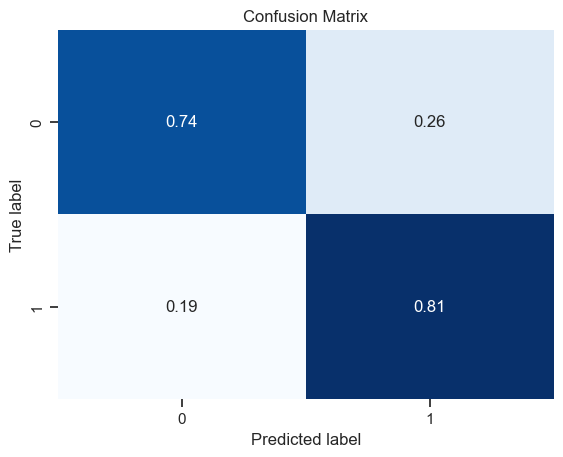

In [37]:
y_pred = pipeline.predict(X_test)
report_dict = classification_report(y_test, y_pred, output_dict=True)
pr_auc = average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1])
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)
accuracy = report_dict["accuracy"]
recall = (
    report_dict["1.0"]["recall"] if "1.0" in report_dict else 0
)  # Recall for positive class
# F1-score for positive class
f1_score = report_dict["1.0"]["f1-score"] if "1.0" in report_dict else 0
# Calculate precision for positive class
positive_precision = precision_score(y_test, y_pred, pos_label=1)

print(classification_report(y_test, y_pred))
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print("F1-score: ", f1_score)
print("PR AUC Score: ", pr_auc)
print("Balanced Accuracy Score: ", balanced_accuracy)


# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False)

# Set the title and labels for the subplot
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

## Converting and Saving Best Model to ONNX Format

In [38]:
initial_types = [('input', FloatTensorType([None, X_train.shape[1]]))]
final_types = [('label', Int64TensorType([None])),
              ('output', FloatTensorType([None, 2]))]

In [39]:
# Convert the best model to ONNX format with initial types
onnx_model = convert_sklearn(
    pipeline,
    "best_model",
    initial_types=initial_types,
    final_types=final_types,
    options={"zipmap": False},
)

# Infer shapes (optional but recommended)
onnx_model = shape_inference.infer_shapes(onnx_model)

# Define the path to save the ONNX model with timestamp
onnx_file_path = f"..\\models\\best_model.onnx"

# Save the ONNX model to a file
onnx.save_model(onnx_model, onnx_file_path)
joblib.dump(pipeline, "..\\models\\best_model_pipeline.pkl")

# Log the saved best model
logger.info(f"Best model saved successfully at '{onnx_file_path}'.")

2024-03-09 11:50:03 - INFO - Best model saved successfully at '..\models\best_model.onnx'.


## Testing onnx model

In [277]:
target_test_value = 0
# X_test_single_row = np.array(df[df[target_column] == target_test_value].iloc[:, 1:].head(10).values)
X_test_single_row = np.array(
    df[df[target_column] == target_test_value].iloc[:, 1:].head(10).values
)
print(repr(X_test_single_row))
# Create an ONNX inference session with the loaded model
onnx_session = InferenceSession("..\\models\\best_model.onnx")
best_pipeline = joblib.load("..\\models\\best_model_pipeline.pkl")

print(onnx_session)
output_meta_names = [output.name for output in onnx_session.get_outputs()]
print("Output metadata names:", output_meta_names)

# Convert the input data to a dictionary with the appropriate key
# input_data = {'input': X_test_single_row.astype(np.float32)}
input_data = {"input": X_test_single_row.astype(np.float32)}

# Run inference with the ONNX model
output = onnx_session.run(None, input_data)
print(output)

# Assuming you have only one output, you can access it like this
output_data = output[0]
print(sum(output_data == target_test_value) / len(output_data))

array([[ 1.,  1.,  1., 40.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         5., 18., 15.,  1.,  0.,  9.,  4.,  3.],
       [ 0.,  0.,  0., 25.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         3.,  0.,  0.,  0.,  0.,  7.,  6.,  1.],
       [ 1.,  1.,  1., 28.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
         5., 30., 30.,  1.,  0.,  9.,  4.,  8.],
       [ 1.,  0.,  1., 27.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
         2.,  0.,  0.,  0.,  0., 11.,  3.,  6.],
       [ 1.,  1.,  1., 24.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
         2.,  3.,  0.,  0.,  0., 11.,  5.,  4.],
       [ 1.,  1.,  1., 25.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,
         2.,  0.,  2.,  0.,  1., 10.,  6.,  8.],
       [ 1.,  0.,  1., 30.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         3.,  0., 14.,  0.,  0.,  9.,  6.,  7.],
       [ 1.,  1.,  1., 25.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
         3.,  0.,  0.,  1.,  0., 11.,  4.,  4.],
       [ 0.,  0.,  1., 2

In [282]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
# X_train_summary = shap.kmeans(X_train, 10)
# print(X_train.values)

SHAP_X_train0 = best_pipeline.named_steps["scaler"].transform(X_train_resampled)
SHAP_X_train1 = best_pipeline.named_steps["poly_features"].transform(SHAP_X_train0)

SHAP_X_test0 = best_pipeline.named_steps["scaler"].transform(X_test)
SHAP_X_test1 = best_pipeline.named_steps["poly_features"].transform(SHAP_X_test0)

# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
# Reduce the number to make the process faster
shape_instances = 1000  # N instances for use as the background distribution
SHAP_X_train = shap.utils.sample(SHAP_X_train1, shape_instances, random_state=42)
SHAP_X_test = shap.utils.sample(SHAP_X_test1, shape_instances, random_state=42)

explainer = shap.KernelExplainer(
    best_pipeline.named_steps["classifier"].predict_proba, SHAP_X_train
)
shap_values = explainer(SHAP_X_test)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1000/1000 [6:59:08<00:00, 25.15s/it] 


In [285]:
new_poly_features = best_pipeline.named_steps["poly_features"].get_feature_names_out(all_features)

shap_values.feature_names = new_poly_features

# Take the 1's
small_shap_values = shap_values[:,:len(new_poly_features),1]
expected_value = explainer.expected_value

vals = np.abs(small_shap_values.values).mean(0)
feature_names = new_poly_features

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
top_important_feature = feature_importance.iloc[:20, 0].values


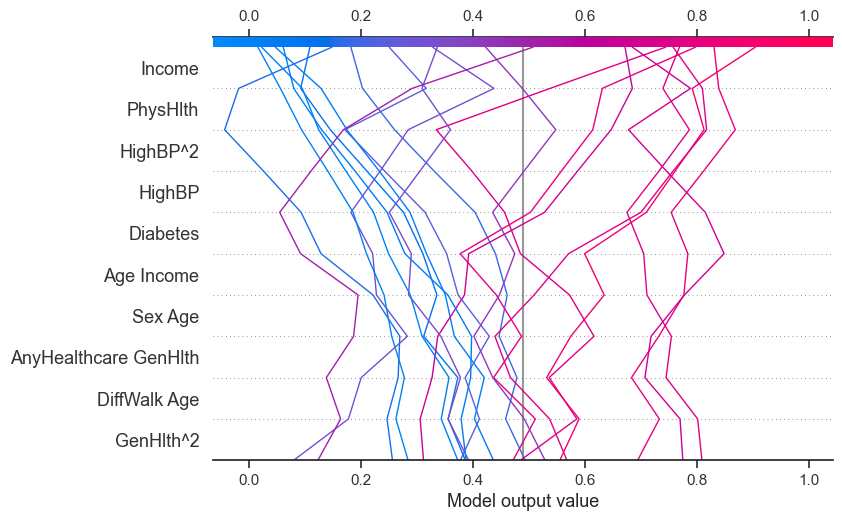

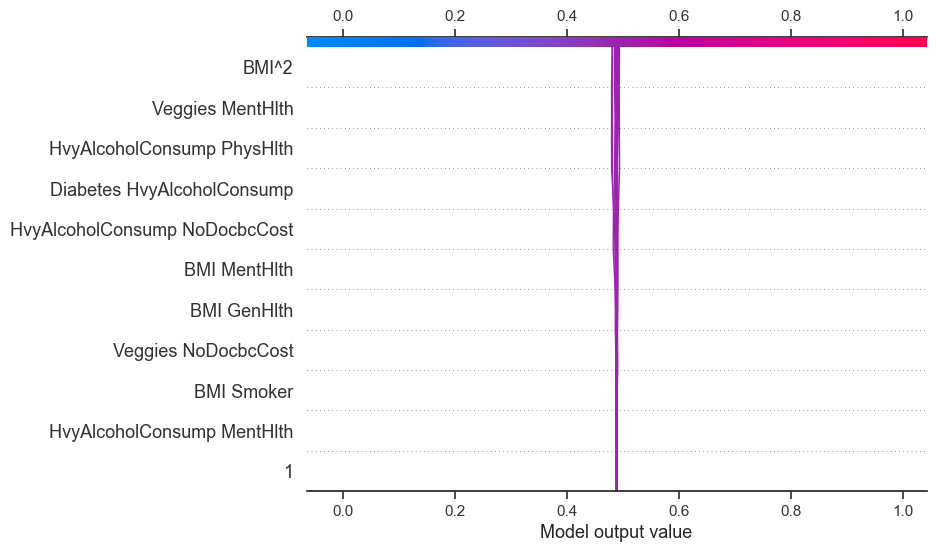

In [317]:
%matplotlib inline

# print(shap_values[:, 0, 1])
# visualize the first prediction's explanation
# shap.plots.scatter(small_shap_values[:, "Income"], color=small_shap_values)
# shap.plots.bar(small_shap_values, max_display=20)
# shap.plots.heatmap(small_shap_values, instance_order=shap.Explanation.sum(1))
# shap.plots.force(
#     explainer.expected_value[1], small_shap_values.values, features=new_poly_features
# )

sex = [
    "Women" if small_shap_values[i, "Sex"].data == 0 else "Men"
    for i in range(small_shap_values.shape[0])
]
shap.plots.bar(small_shap_values.cohorts(sex).abs.mean(0))

shap.plots.violin(small_shap_values, feature_names=new_poly_features, max_display=20, plot_type="violin")

shap.plots.beeswarm(
    small_shap_values, max_display=20, order=shap.Explanation.abs.mean(0)
)

# Define the first slice object
lenght_features = 10
slice1 = slice(-1, -lenght_features-1, -1)

# Define the second slice object
slice2 = slice(-len(new_poly_features)+lenght_features, -len(new_poly_features)-1, -1)

# Combine the two plots
r1 = shap.plots.decision(
    explainer.expected_value[1],
    small_shap_values.values[:20],
    new_poly_features,
    feature_order="importance",
    # feature_display_range=slice(-1, -len(new_poly_features)-1, -1),
    feature_display_range=slice1,
    return_objects=True,
    ignore_warnings=True
)
shap.plots.decision(
    explainer.expected_value[1],
    small_shap_values.values[:20],
    new_poly_features,
    feature_order="importance",
    # feature_display_range=slice(-1, -len(new_poly_features)-1, -1),
    feature_display_range=slice2,
    xlim=r1.xlim,
    ignore_warnings=True
)

# shap.summary_plot(small_shap_values, SHAP_X_test, plot_size=(20,6))

Order for input:

1. HighBP
2. HighChol
3. CholCheck
4. BMI
5. Smoker
6. Stroke
7. Diabetes
8. PhysActivity
9. Fruits
10. Veggies
11. HvyAlcoholConsump
12. AnyHealthcare
13. NoDocbcCost
14. GenHlth
15. MentHlth
16. PhysHlth
17. DiffWalk
18. Sex
19. Age
20. Education
21. Income
